## Import bibliotek

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import numpy as np
import mlflow

#mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

## Wczytanie i wstępna analiza danych

### Wczytanie danych

In [2]:
df = pd.read_csv("https://pwozniak.kia.prz.edu.pl/files/uczeniemaszynowe/train_data.csv")
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,59,Arcanine,Fire,NaN,555,82,110,88,105,72,98,1,False
1,107,Hitmonchan,Fighting,NaN,455,47,97,84,27,121,79,1,False
2,123,Scyther,Bug,Flying,500,63,113,86,56,73,109,1,False
3,35,Clefairy,Fairy,NaN,323,67,54,46,58,62,36,1,False
4,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,97,193,102,157,98,133,1,True


### Podstawowe statyski i rozkłady

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3320 entries, 0 to 3319
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           3320 non-null   int64 
 1   Name        3320 non-null   object
 2   Type 1      3320 non-null   object
 3   Type 2      1560 non-null   object
 4   Total       3320 non-null   int64 
 5   HP          3320 non-null   int64 
 6   Attack      3320 non-null   int64 
 7   Defense     3320 non-null   int64 
 8   Sp. Atk     3320 non-null   int64 
 9   Sp. Def     3320 non-null   int64 
 10  Speed       3320 non-null   int64 
 11  Generation  3320 non-null   int64 
 12  Legendary   3320 non-null   bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 314.6+ KB


In [11]:
df.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,3320.000000,3320.000000,3320.000000,3320.000000,3320.000000,3320.000000,3320.000000,3320.000000,3320.0
mean,75.819277,426.813253,65.925000,76.491867,70.749398,71.862048,69.129217,72.655723,1.0
std,45.023818,115.545921,28.591967,31.307924,29.011751,34.865423,26.255710,30.095827,0.0
min,1.000000,195.000000,-1.000000,-1.000000,-1.000000,5.000000,10.000000,5.000000,1.0
25%,36.000000,325.000000,47.000000,54.000000,50.000000,46.000000,49.000000,49.000000,1.0
50%,76.500000,436.500000,62.000000,74.000000,67.000000,65.000000,70.000000,71.000000,1.0
75%,115.000000,500.000000,81.000000,96.000000,87.000000,94.000000,88.000000,93.000000,1.0
max,151.000000,780.000000,255.000000,199.000000,189.000000,202.000000,137.000000,159.000000,1.0


In [12]:
df.describe(include='O')

,Name,Type 1,Type 2
count,3320,3320,1560
unique,166,15,13
top,Arcanine,Water,Flying
freq,20,620,460


### Weryfikacja brakujących wartości

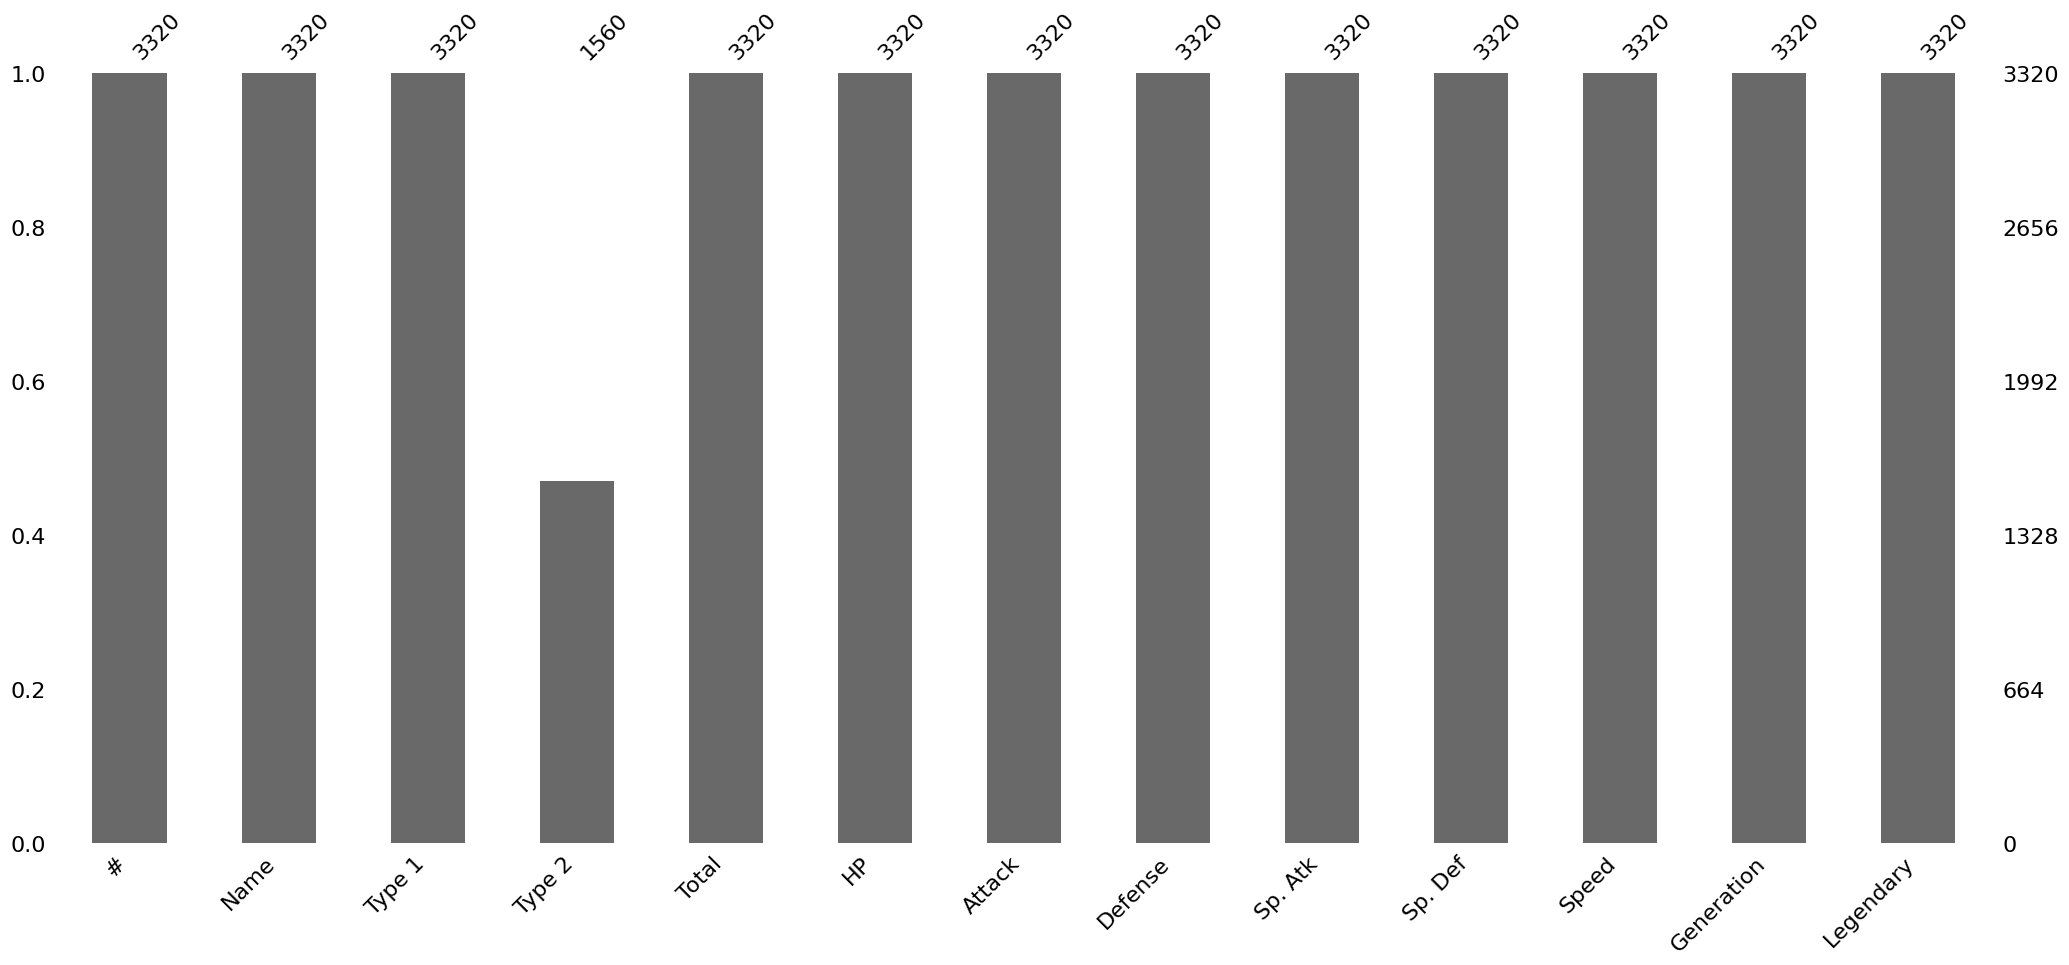

In [16]:
msno.bar(df)
plt.show()

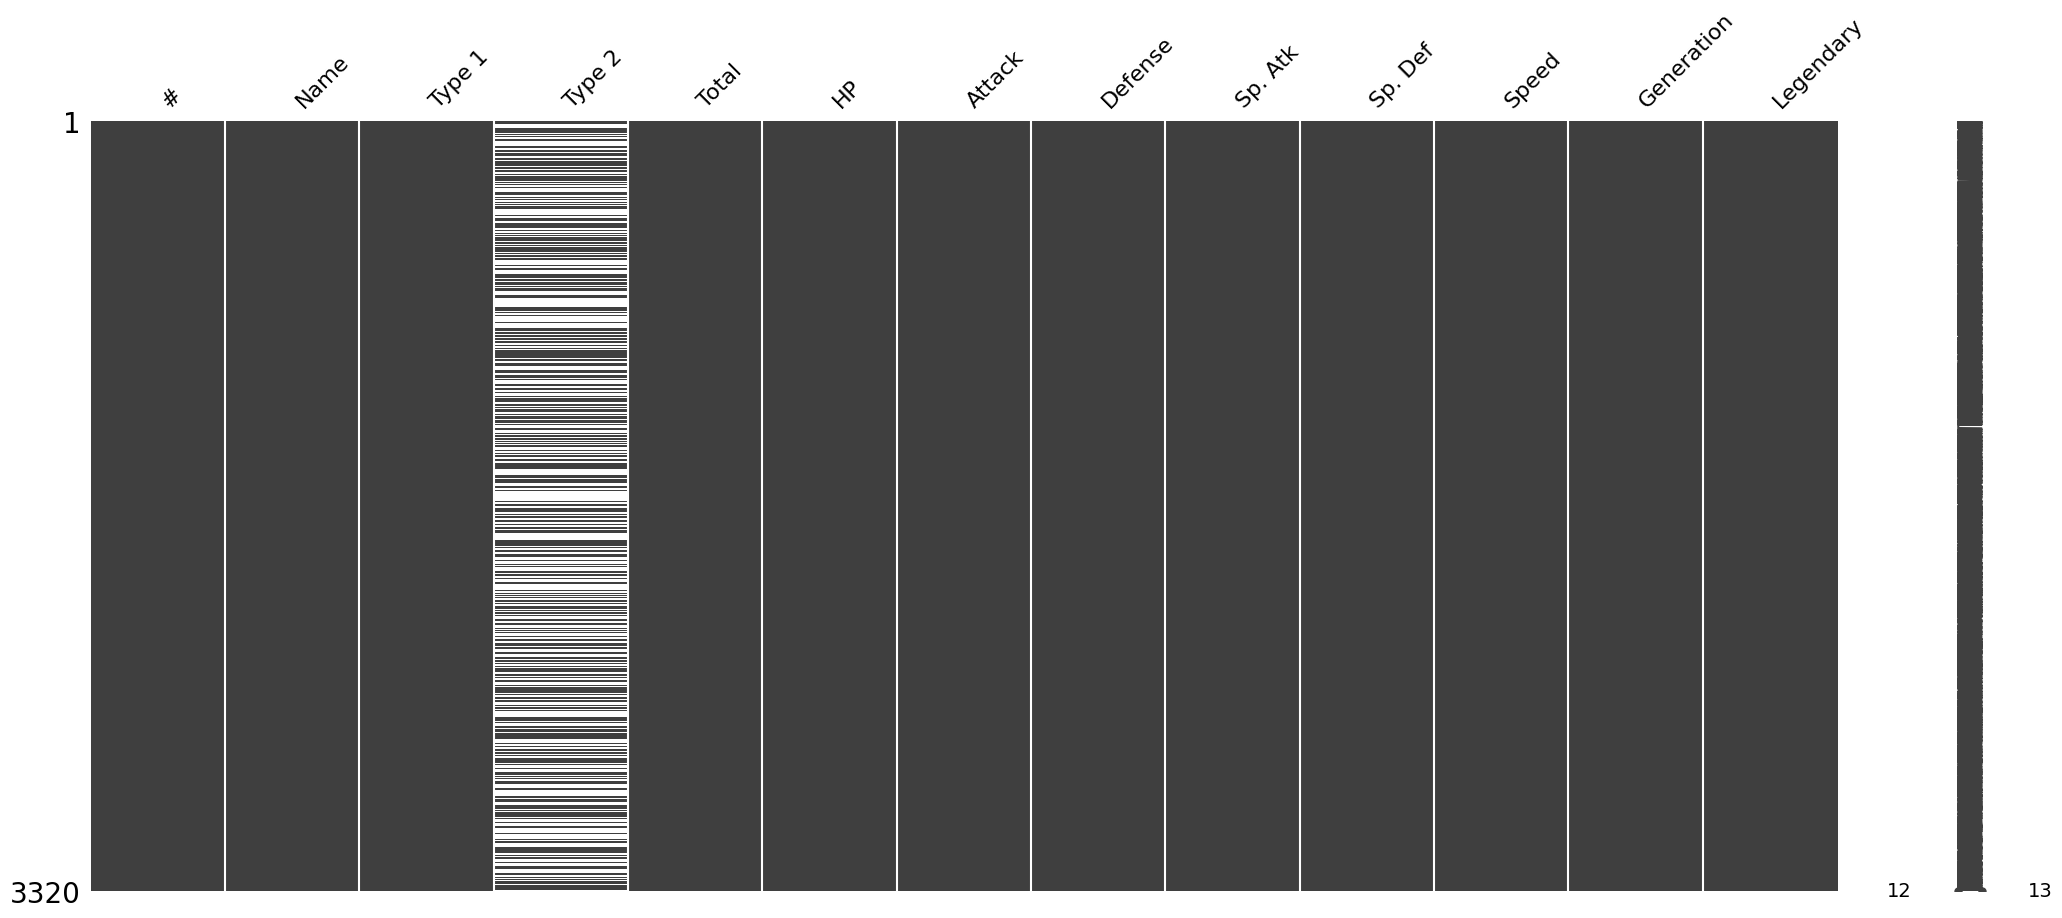

In [21]:
msno.matrix(df)
plt.show()

## Przygotowanie danych dla klasyfikatora

### Obsługa brakujących wartości oraz usuwanie błędnych wartości

In [3]:
df_no_nans = df.fillna('Other')
df_no_nans.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,59,Arcanine,Fire,Other,555,82,110,88,105,72,98,1,False
1,107,Hitmonchan,Fighting,Other,455,47,97,84,27,121,79,1,False
2,123,Scyther,Bug,Flying,500,63,113,86,56,73,109,1,False
3,35,Clefairy,Fairy,Other,323,67,54,46,58,62,36,1,False
4,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,97,193,102,157,98,133,1,True


In [4]:
df_clean = df_no_nans[(df_no_nans.HP > 0) & (df_no_nans.Attack > 0) & (df_no_nans.Defense > 0)].reset_index(drop=True)

columns = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
for column in columns:
    print(f"Wiersze w {column} które mają wartość poniżej lub równe 0: {len(df_clean[df_clean[column] <= 0])}")

Wiersze w Total które mają wartość poniżej lub równe 0: 0
Wiersze w HP które mają wartość poniżej lub równe 0: 0
Wiersze w Attack które mają wartość poniżej lub równe 0: 0
Wiersze w Defense które mają wartość poniżej lub równe 0: 0
Wiersze w Sp. Atk które mają wartość poniżej lub równe 0: 0
Wiersze w Sp. Def które mają wartość poniżej lub równe 0: 0
Wiersze w Speed które mają wartość poniżej lub równe 0: 0


### Kodowanie zmiennych kategorycznych

In [5]:
label_enc = LabelEncoder()
df_cat = pd.DataFrame()
for column in ['Name', 'Type 1', 'Type 2']:
    df_cat[column] = label_enc.fit_transform(df_clean[column])
df_cat

,Name,Type 1,Type 2
0,6,5,8
1,60,4,8
2,133,0,4
3,23,3,8
4,92,12,3
...,...,...,...
3303,151,0,9
3304,35,8,8
3305,6,5,8
3306,103,5,8


### Normalizacja danych liczbowych

In [6]:
df_num = df_clean[['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
df_num

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,555,82,110,88,105,72,98
1,455,47,97,84,27,121,79
2,500,63,113,86,56,73,109
3,323,67,54,46,58,62,36
4,780,97,193,102,157,98,133
...,...,...,...,...,...,...,...
3303,450,75,64,60,82,78,91
3304,405,40,83,43,45,71,123
3305,555,96,113,79,94,86,87
3306,505,66,79,76,74,100,110


In [7]:
minmax_scaler = MinMaxScaler()
columns = df_num.columns
np_num = minmax_scaler.fit_transform(df_num)
df_num_norm = pd.DataFrame(np_num, columns=columns)
df_num_norm

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,0.615385,0.318898,0.550505,0.459893,0.507614,0.488189,0.603896
1,0.444444,0.181102,0.484848,0.438503,0.111675,0.874016,0.480519
2,0.521368,0.244094,0.565657,0.449198,0.258883,0.496063,0.675325
3,0.218803,0.259843,0.267677,0.235294,0.269036,0.409449,0.201299
4,1.000000,0.377953,0.969697,0.534759,0.771574,0.692913,0.831169
...,...,...,...,...,...,...,...
3303,0.435897,0.291339,0.318182,0.310160,0.390863,0.535433,0.558442
3304,0.358974,0.153543,0.414141,0.219251,0.203046,0.480315,0.766234
3305,0.615385,0.374016,0.565657,0.411765,0.451777,0.598425,0.532468
3306,0.529915,0.255906,0.393939,0.395722,0.350254,0.708661,0.681818


In [8]:
df_prepared = pd.concat([df_num_norm, df_cat, df_clean['Generation']], axis=1)
df_prepared

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Name,Type 1,Type 2,Generation
0,0.615385,0.318898,0.550505,0.459893,0.507614,0.488189,0.603896,6,5,8,1
1,0.444444,0.181102,0.484848,0.438503,0.111675,0.874016,0.480519,60,4,8,1
2,0.521368,0.244094,0.565657,0.449198,0.258883,0.496063,0.675325,133,0,4,1
3,0.218803,0.259843,0.267677,0.235294,0.269036,0.409449,0.201299,23,3,8,1
4,1.000000,0.377953,0.969697,0.534759,0.771574,0.692913,0.831169,92,12,3,1
...,...,...,...,...,...,...,...,...,...,...,...
3303,0.435897,0.291339,0.318182,0.310160,0.390863,0.535433,0.558442,151,0,9,1
3304,0.358974,0.153543,0.414141,0.219251,0.203046,0.480315,0.766234,35,8,8,1
3305,0.615385,0.374016,0.565657,0.411765,0.451777,0.598425,0.532468,6,5,8,1
3306,0.529915,0.255906,0.393939,0.395722,0.350254,0.708661,0.681818,103,5,8,1


## Przewidywanie nazwy pokemona

### Funkcja pomocniczna do trenowania i testowania

In [35]:
def train(clf, X, y):
    for test_split in [0.1, 0.2, 0.3, 0.4]:
        print(f"Train size: {(1 - test_split) * 100}%, Test size: {test_split * 100}%")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(f"Accuracy: {np.round(accuracy_score(y_pred=y_pred, y_true=y_test), 3)}")
        print(f"Precision: {np.round(precision_score(y_pred=y_pred, y_true=y_test, average='micro'), 3)}")
        print(f"Recall: {np.round(recall_score(y_pred=y_pred, y_true=y_test, average='micro'), 3)}")
        print(f"F1-score: {np.round(f1_score(y_pred=y_pred, y_true=y_test, average='micro'), 3)}")

In [36]:
X = df_prepared[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
y = df_cat.Name
#mlflow.set_experiment("Predict Pokemons Name")

### Regresja logistyczna

In [37]:
log_reg = LogisticRegression()
train(log_reg, X, y)

Train size: 90.0%, Test size: 10.0%
Accuracy: 0.254
Precision: 0.254
Recall: 0.254
F1-score: 0.254
Train size: 80.0%, Test size: 20.0%
Accuracy: 0.233
Precision: 0.233
Recall: 0.233
F1-score: 0.233
Train size: 70.0%, Test size: 30.0%
Accuracy: 0.242
Precision: 0.242
Recall: 0.242
F1-score: 0.242
Train size: 60.0%, Test size: 40.0%
Accuracy: 0.222
Precision: 0.222
Recall: 0.222
F1-score: 0.222


### Drzewo decyzyjne

In [38]:
dt_clf = DecisionTreeClassifier(random_state=42)
train(dt_clf, X, y)

Train size: 90.0%, Test size: 10.0%
Accuracy: 0.764
Precision: 0.764
Recall: 0.764
F1-score: 0.764
Train size: 80.0%, Test size: 20.0%
Accuracy: 0.79
Precision: 0.79
Recall: 0.79
F1-score: 0.79
Train size: 70.0%, Test size: 30.0%
Accuracy: 0.761
Precision: 0.761
Recall: 0.761
F1-score: 0.761
Train size: 60.0%, Test size: 40.0%
Accuracy: 0.748
Precision: 0.748
Recall: 0.748
F1-score: 0.748


### Las losowy

In [39]:
rf_clf = RandomForestClassifier(random_state=42)
train(rf_clf, X, y)

Train size: 90.0%, Test size: 10.0%
Accuracy: 0.915
Precision: 0.915
Recall: 0.915
F1-score: 0.915
Train size: 80.0%, Test size: 20.0%
Accuracy: 0.903
Precision: 0.903
Recall: 0.903
F1-score: 0.903
Train size: 70.0%, Test size: 30.0%
Accuracy: 0.892
Precision: 0.892
Recall: 0.892
F1-score: 0.892
Train size: 60.0%, Test size: 40.0%
Accuracy: 0.894
Precision: 0.894
Recall: 0.894
F1-score: 0.894


### K-NN

In [40]:
knn_clf = KNeighborsClassifier()
train(knn_clf, X, y)

Train size: 90.0%, Test size: 10.0%
Accuracy: 0.888
Precision: 0.888
Recall: 0.888
F1-score: 0.888
Train size: 80.0%, Test size: 20.0%
Accuracy: 0.894
Precision: 0.894
Recall: 0.894
F1-score: 0.894
Train size: 70.0%, Test size: 30.0%
Accuracy: 0.896
Precision: 0.896
Recall: 0.896
F1-score: 0.896
Train size: 60.0%, Test size: 40.0%
Accuracy: 0.888
Precision: 0.888
Recall: 0.888
F1-score: 0.888


### SVM

In [41]:
svc_clf = SVC()
train(svc_clf, X, y)

Train size: 90.0%, Test size: 10.0%
Accuracy: 0.891
Precision: 0.891
Recall: 0.891
F1-score: 0.891
Train size: 80.0%, Test size: 20.0%
Accuracy: 0.896
Precision: 0.896
Recall: 0.896
F1-score: 0.896
Train size: 70.0%, Test size: 30.0%
Accuracy: 0.87
Precision: 0.87
Recall: 0.87
F1-score: 0.87
Train size: 60.0%, Test size: 40.0%
Accuracy: 0.856
Precision: 0.856
Recall: 0.856
F1-score: 0.856


## Przewidywanie pierwszego typu Pokemona

In [42]:
X = df_prepared[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
y = df_cat['Type 1']
#mlflow.set_experiment("Predict Pokemons Type 1")

### Regresja logistyczna

In [43]:
log_reg = LogisticRegression()
train(log_reg, X, y)

Train size: 90.0%, Test size: 10.0%
Accuracy: 0.347
Precision: 0.347
Recall: 0.347
F1-score: 0.347
Train size: 80.0%, Test size: 20.0%
Accuracy: 0.356
Precision: 0.356
Recall: 0.356
F1-score: 0.356
Train size: 70.0%, Test size: 30.0%
Accuracy: 0.36
Precision: 0.36
Recall: 0.36
F1-score: 0.36
Train size: 60.0%, Test size: 40.0%
Accuracy: 0.355
Precision: 0.355
Recall: 0.355
F1-score: 0.355


### Drzewo decyzyjne

In [44]:
dt_clf = DecisionTreeClassifier(random_state=42)
train(dt_clf, X, y)

Train size: 90.0%, Test size: 10.0%
Accuracy: 0.798
Precision: 0.798
Recall: 0.798
F1-score: 0.798
Train size: 80.0%, Test size: 20.0%
Accuracy: 0.776
Precision: 0.776
Recall: 0.776
F1-score: 0.776
Train size: 70.0%, Test size: 30.0%
Accuracy: 0.773
Precision: 0.773
Recall: 0.773
F1-score: 0.773
Train size: 60.0%, Test size: 40.0%
Accuracy: 0.739
Precision: 0.739
Recall: 0.739
F1-score: 0.739


### Las losowy

In [45]:
rf_clf = RandomForestClassifier(random_state=42)
train(rf_clf, X, y)

Train size: 90.0%, Test size: 10.0%
Accuracy: 0.909
Precision: 0.909
Recall: 0.909
F1-score: 0.909
Train size: 80.0%, Test size: 20.0%
Accuracy: 0.899
Precision: 0.899
Recall: 0.899
F1-score: 0.899
Train size: 70.0%, Test size: 30.0%
Accuracy: 0.901
Precision: 0.901
Recall: 0.901
F1-score: 0.901
Train size: 60.0%, Test size: 40.0%
Accuracy: 0.887
Precision: 0.887
Recall: 0.887
F1-score: 0.887


### KNN

In [31]:
knn_clf = KNeighborsClassifier()
train(knn_clf)

Train size: 90.0%, Test size: 10.0%
Accuracy: 0.924
Precision: 0.924
Recall: 0.924
F1-score: 0.924
Train size: 80.0%, Test size: 20.0%
Accuracy: 0.924
Precision: 0.924
Recall: 0.924
F1-score: 0.924
Train size: 70.0%, Test size: 30.0%
Accuracy: 0.925
Precision: 0.925
Recall: 0.925
F1-score: 0.925
Train size: 60.0%, Test size: 40.0%
Accuracy: 0.922
Precision: 0.922
Recall: 0.922
F1-score: 0.922


### SVM

In [46]:
svc_clf = SVC()
train(svc_clf, X, y)

Train size: 90.0%, Test size: 10.0%
Accuracy: 0.776
Precision: 0.776
Recall: 0.776
F1-score: 0.776
Train size: 80.0%, Test size: 20.0%
Accuracy: 0.767
Precision: 0.767
Recall: 0.767
F1-score: 0.767
Train size: 70.0%, Test size: 30.0%
Accuracy: 0.764
Precision: 0.764
Recall: 0.764
F1-score: 0.764
Train size: 60.0%, Test size: 40.0%
Accuracy: 0.744
Precision: 0.744
Recall: 0.744
F1-score: 0.744


### Przewidywanie drugiego typu Pokemona

In [48]:
X = df_prepared[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
y = df_cat['Type 2']
#mlflow.set_experiment("Predict Pokemons Type 2")

### Regresja logistyczna

In [49]:
log_reg = LogisticRegression()
train(log_reg, X, y)

Train size: 90.0%, Test size: 10.0%
Accuracy: 0.489
Precision: 0.489
Recall: 0.489
F1-score: 0.489
Train size: 80.0%, Test size: 20.0%
Accuracy: 0.491
Precision: 0.491
Recall: 0.491
F1-score: 0.491
Train size: 70.0%, Test size: 30.0%
Accuracy: 0.515
Precision: 0.515
Recall: 0.515
F1-score: 0.515
Train size: 60.0%, Test size: 40.0%
Accuracy: 0.526
Precision: 0.526
Recall: 0.526
F1-score: 0.526


### Drzewo decyzyjne

In [52]:
dt_clf = DecisionTreeClassifier(random_state=42)
train(dt_clf, X, y)

Train size: 90.0%, Test size: 10.0%
Accuracy: 0.843
Precision: 0.843
Recall: 0.843
F1-score: 0.843
Train size: 80.0%, Test size: 20.0%
Accuracy: 0.807
Precision: 0.807
Recall: 0.807
F1-score: 0.807
Train size: 70.0%, Test size: 30.0%
Accuracy: 0.81
Precision: 0.81
Recall: 0.81
F1-score: 0.81
Train size: 60.0%, Test size: 40.0%
Accuracy: 0.804
Precision: 0.804
Recall: 0.804
F1-score: 0.804


### Las losowy

In [53]:
rf_clf = RandomForestClassifier(random_state=42)
train(rf_clf, X, y)

Train size: 90.0%, Test size: 10.0%
Accuracy: 0.934
Precision: 0.934
Recall: 0.934
F1-score: 0.934
Train size: 80.0%, Test size: 20.0%
Accuracy: 0.915
Precision: 0.915
Recall: 0.915
F1-score: 0.915
Train size: 70.0%, Test size: 30.0%
Accuracy: 0.914
Precision: 0.914
Recall: 0.914
F1-score: 0.914
Train size: 60.0%, Test size: 40.0%
Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1-score: 0.91


### KNN

In [54]:
knn_clf = KNeighborsClassifier()
train(knn_clf, X, y)

Train size: 90.0%, Test size: 10.0%
Accuracy: 0.934
Precision: 0.934
Recall: 0.934
F1-score: 0.934
Train size: 80.0%, Test size: 20.0%
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1-score: 0.94
Train size: 70.0%, Test size: 30.0%
Accuracy: 0.945
Precision: 0.945
Recall: 0.945
F1-score: 0.945
Train size: 60.0%, Test size: 40.0%
Accuracy: 0.942
Precision: 0.942
Recall: 0.942
F1-score: 0.942


### SVM

In [55]:
svm_clf = SVC()
train(svm_clf, X, y)

Train size: 90.0%, Test size: 10.0%
Accuracy: 0.792
Precision: 0.792
Recall: 0.792
F1-score: 0.792
Train size: 80.0%, Test size: 20.0%
Accuracy: 0.757
Precision: 0.757
Recall: 0.757
F1-score: 0.757
Train size: 70.0%, Test size: 30.0%
Accuracy: 0.776
Precision: 0.776
Recall: 0.776
F1-score: 0.776
Train size: 60.0%, Test size: 40.0%
Accuracy: 0.768
Precision: 0.768
Recall: 0.768
F1-score: 0.768
